In [41]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve
import scipy.optimize as tnc
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

In [42]:
equity_df = fetch_sql_code('''select * from equity_value_data''')
equity_df.head(10)

,timestamp,close_equity,user_id
0,2016-10-03,27.2775,f5fc78a6931c205931827765e5b853f8
1,2016-10-04,24.9530,f5fc78a6931c205931827765e5b853f8
2,2016-10-05,27.5455,f5fc78a6931c205931827765e5b853f8
3,2016-10-06,26.8200,f5fc78a6931c205931827765e5b853f8
4,2016-10-07,25.9181,f5fc78a6931c205931827765e5b853f8
5,2016-10-10,26.2965,f5fc78a6931c205931827765e5b853f8
6,2016-10-11,25.3980,f5fc78a6931c205931827765e5b853f8
7,2016-10-12,24.6895,f5fc78a6931c205931827765e5b853f8
8,2016-10-13,28.1303,f5fc78a6931c205931827765e5b853f8
9,2016-10-14,28.0159,f5fc78a6931c205931827765e5b853f8


In [43]:
'''
1. Equity Volatility (Standard Deviation of Equity)
Why it's useful: Volatility is a key measure in finance, as it represents the risk or stability of a user’s portfolio over time. High volatility could indicate speculative behavior, which might correlate with churn or certain types of investment activity.
1sd = 68% of the time the data is covereed + or -
2sd = 95% of the timethe data is bewteen + or - (mean +/- sd value)
3sd = 99.7% of the time the data is bewten + or - (mean +/- sd value @ 3)

'''
new_df = equity_df.groupby('user_id')['close_equity'].std().reset_index()
new_df.columns = ['user_id', 'equity_volatility']
new_df

,user_id,equity_volatility
0,0012db34aa7b083f5714e7831195e54d,191.975127
1,001d6c77dbdb3213cead7673f250bfdc,449.330147
2,002e4653171ddc61c3cd30603cd7bd3e,6.480472
3,00384fa9be6fdca1b786bae70d78f88f,24.522490
4,0042aac295a0d4df88f4b83012778bd4,933.690027
...,...,...
5579,ff9ee08791e20724a86995ab2bc72578,47.137114
5580,ffa12d2f97e310910291f9b26fb2318d,1577.089485
5581,ffae713096867a32e74f633060667153,7.194193
5582,ffbda9a14e07718e2b21fb03896d21c5,191.038205


In [44]:
'''
2. Rolling Average Equity (Smoothing Trends)
Why it's useful: A rolling average smooths out short-term fluctuations in the equity value and highlights longer-term trends. This feature can capture the general trajectory of a user’s equity over time.
How to calculate: Apply a rolling average over a window of time (e.g., 7 days or 30 days).
'''
equity_df['rolling_avg_equity_7d'] = equity_df.groupby('user_id')['close_equity'].rolling(window=7).mean().reset_index(level=0, drop=True)
equity_df

,timestamp,close_equity,user_id,rolling_avg_equity_7d
0,2016-10-03,27.2775,f5fc78a6931c205931827765e5b853f8,NaN
1,2016-10-04,24.9530,f5fc78a6931c205931827765e5b853f8,NaN
2,2016-10-05,27.5455,f5fc78a6931c205931827765e5b853f8,NaN
3,2016-10-06,26.8200,f5fc78a6931c205931827765e5b853f8,NaN
4,2016-10-07,25.9181,f5fc78a6931c205931827765e5b853f8,NaN
...,...,...,...,...
1119153,2016-09-26,21.9035,f5fc78a6931c205931827765e5b853f8,22.538457
1119154,2016-09-27,22.0865,f5fc78a6931c205931827765e5b853f8,22.502000
1119155,2016-09-28,24.4820,f5fc78a6931c205931827765e5b853f8,22.742500
1119156,2016-09-29,23.7011,f5fc78a6931c205931827765e5b853f8,22.892014


In [20]:
'''
Equity Growth Rate (Daily or Weekly):
Why it's useful: Growth rate measures how fast a user’s equity value is changing, which can indicate whether they are increasing their account balance steadily or depleting it.
How to calculate: Compute the percentage change in equity for each day.
'''
new_df['equity_growth_rate'] = equity_df.groupby('user_id')['close_equity'].pct_change()
new_df


,user_id,equity_volatility,rolling_avg_equity_7d,equity_growth_rate
0,0012db34aa7b083f5714e7831195e54d,191.975127,NaN,NaN
1,001d6c77dbdb3213cead7673f250bfdc,449.330147,NaN,-0.085217
2,002e4653171ddc61c3cd30603cd7bd3e,6.480472,NaN,0.103895
3,00384fa9be6fdca1b786bae70d78f88f,24.522490,NaN,-0.026338
4,0042aac295a0d4df88f4b83012778bd4,933.690027,NaN,-0.033628
...,...,...,...,...
5579,ff9ee08791e20724a86995ab2bc72578,47.137114,17585.025714,-0.001136
5580,ffa12d2f97e310910291f9b26fb2318d,1577.089485,17526.531429,0.001747
5581,ffae713096867a32e74f633060667153,7.194193,17523.498571,0.002558
5582,ffbda9a14e07718e2b21fb03896d21c5,191.038205,17509.814286,-0.012707


In [27]:
'''

Total Active Days (Days Equity > $10):
Why it's useful: This represents the total number of days a user had more than $10 in their account, which is a proxy for engagement or activity.
How to calculate: Count the number of distinct days a user is present in the equity table.
'''
active_days = equity_df.groupby('user_id')['timestamp'].nunique()
active_days.columns = ['user_id', 'total_active_days']
active_days

new_df = new_df.merge(active_days, on='user_id', how='left')
new_df

,user_id,equity_volatility,rolling_avg_equity_7d,equity_growth_rate,total_active_days,timestamp_x,timestamp_y
0,0012db34aa7b083f5714e7831195e54d,191.975127,NaN,NaN,NaN,252,252
1,001d6c77dbdb3213cead7673f250bfdc,449.330147,NaN,-0.085217,NaN,252,252
2,002e4653171ddc61c3cd30603cd7bd3e,6.480472,NaN,0.103895,NaN,128,128
3,00384fa9be6fdca1b786bae70d78f88f,24.522490,NaN,-0.026338,NaN,124,124
4,0042aac295a0d4df88f4b83012778bd4,933.690027,NaN,-0.033628,NaN,252,252
...,...,...,...,...,...,...,...
5579,ff9ee08791e20724a86995ab2bc72578,47.137114,17585.025714,-0.001136,NaN,252,252
5580,ffa12d2f97e310910291f9b26fb2318d,1577.089485,17526.531429,0.001747,NaN,252,252
5581,ffae713096867a32e74f633060667153,7.194193,17523.498571,0.002558,NaN,224,224
5582,ffbda9a14e07718e2b21fb03896d21c5,191.038205,17509.814286,-0.012707,NaN,129,129


In [29]:
'''
Average Equity Per Active Period:
Why it's useful: This metric captures the average equity value a user maintains during periods when they have more than $10. It gives an indication of their general investment level.
How to calculate: Calculate the average close_equity value for each user across their active periods.
'''
avg_equity = equity_df.groupby('user_id')['close_equity'].mean().reset_index()
avg_equity.columns = ['user_id', 'avg_equity']

new_df = new_df.merge(avg_equity, on='user_id', how='left')
new_df

,user_id,equity_volatility,rolling_avg_equity_7d,equity_growth_rate,total_active_days,timestamp_x,timestamp_y,avg_equity
0,0012db34aa7b083f5714e7831195e54d,191.975127,NaN,NaN,NaN,252,252,609.100576
1,001d6c77dbdb3213cead7673f250bfdc,449.330147,NaN,-0.085217,NaN,252,252,3307.140361
2,002e4653171ddc61c3cd30603cd7bd3e,6.480472,NaN,0.103895,NaN,128,128,117.203750
3,00384fa9be6fdca1b786bae70d78f88f,24.522490,NaN,-0.026338,NaN,124,124,462.786815
4,0042aac295a0d4df88f4b83012778bd4,933.690027,NaN,-0.033628,NaN,252,252,1561.098745
...,...,...,...,...,...,...,...,...
5579,ff9ee08791e20724a86995ab2bc72578,47.137114,17585.025714,-0.001136,NaN,252,252,92.444723
5580,ffa12d2f97e310910291f9b26fb2318d,1577.089485,17526.531429,0.001747,NaN,252,252,6064.207556
5581,ffae713096867a32e74f633060667153,7.194193,17523.498571,0.002558,NaN,224,224,20.166519
5582,ffbda9a14e07718e2b21fb03896d21c5,191.038205,17509.814286,-0.012707,NaN,129,129,337.930856


In [30]:
'''
Equity Value Change from Start to End of Active Period:
Why it's useful: This captures whether a user’s equity is increasing or decreasing from the start of their engagement. A user with decreasing equity might be more prone to churn.
How to calculate: Subtract the first close_equity value from the last for each user.
'''
equity_change = equity_df.groupby('user_id').apply(lambda x: x['close_equity'].iloc[-1] - x['close_equity'].iloc[0]).reset_index()
equity_change.columns = ['user_id', 'equity_change_start_to_end']

new_df = new_df.merge(equity_change, on='user_id', how='left')
new_df


,user_id,equity_volatility,rolling_avg_equity_7d,equity_growth_rate,total_active_days,timestamp_x,timestamp_y,avg_equity,equity_change_start_to_end
0,0012db34aa7b083f5714e7831195e54d,191.975127,NaN,NaN,NaN,252,252,609.100576,-723.8170
1,001d6c77dbdb3213cead7673f250bfdc,449.330147,NaN,-0.085217,NaN,252,252,3307.140361,1225.0250
2,002e4653171ddc61c3cd30603cd7bd3e,6.480472,NaN,0.103895,NaN,128,128,117.203750,34.3800
3,00384fa9be6fdca1b786bae70d78f88f,24.522490,NaN,-0.026338,NaN,124,124,462.786815,-79.7300
4,0042aac295a0d4df88f4b83012778bd4,933.690027,NaN,-0.033628,NaN,252,252,1561.098745,1637.6635
...,...,...,...,...,...,...,...,...,...
5579,ff9ee08791e20724a86995ab2bc72578,47.137114,17585.025714,-0.001136,NaN,252,252,92.444723,-164.6927
5580,ffa12d2f97e310910291f9b26fb2318d,1577.089485,17526.531429,0.001747,NaN,252,252,6064.207556,4697.2507
5581,ffae713096867a32e74f633060667153,7.194193,17523.498571,0.002558,NaN,224,224,20.166519,13.1899
5582,ffbda9a14e07718e2b21fb03896d21c5,191.038205,17509.814286,-0.012707,NaN,129,129,337.930856,-17.1300


In [31]:
'''
Days Since Last Equity Value Above $10:
Why it's useful: This measures the number of days since a user last had more than $10 in their account. Users with long gaps since the last activity might be more likely to churn.
How to calculate: Subtract the most recent equity date from the current date.
'''
# equity_df['days_since_last_equity'] = (pd.to_datetime('today') - equity_df.groupby('user_id')['timestamp'].transform('max')).dt.days


"\nDays Since Last Equity Value Above $10:\nWhy it's useful: This measures the number of days since a user last had more than $10 in their account. Users with long gaps since the last activity might be more likely to churn.\nHow to calculate: Subtract the most recent equity date from the current date.\n"

In [16]:
equity_df['streak_id'] = equity_df.groupby('user_id')['timestamp'].apply(lambda x: (x != x.shift() + pd.Timedelta(days=1)).cumsum())
longest_streak = equity_df.groupby(['user_id', 'streak_id']).size().groupby('user_id').max().reset_index()
longest_streak.columns = ['user_id', 'longest_streak_days']



# # Assuming there's a 'deposit_amount' column
# cumulative_deposits = df2.groupby('user_id')['deposit_amount'].sum().reset_index()
# cumulative_deposits.columns = ['user_id', 'total_deposits']


TypeError: incompatible index of inserted column with frame index

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn_flag', y='equity_volatility', data=equdf)
plt.title('Equity Volatility by Churn Flag')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x='equity_change_start_to_end', y='churn_flag', data=df)
plt.title('Equity Change Start to End vs. Churn Flag')
plt.show()


df = df.merge(equity_volatility, on='user_id', how='left')
df = df.merge(avg_equity, on='user_id', how='left')
# Continue merging other engineered features



ValueError: Could not interpret value `equity_volatility` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [6]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag,deposit_per_time,is_high_risk
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,1.172009,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,11.380761,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,2.271000,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,49.221480,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,2.176930,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0,32.122379,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1,12.133885,0
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0,2.086187,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0,8.819574,0


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
 9   churn_flag                    5584 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 436.4+ KB


In [4]:
df.describe()

,time_spent,first_deposit_amount,churn_flag
count,5584.000000,5584.000000,5584.000000
mean,34.509706,633.566805,0.049964
std,155.080551,2118.323263,0.217890
min,0.000000,0.000000,0.000000
25%,2.848908,50.000000,0.000000
50%,13.474708,100.000000,0.000000
75%,33.823829,500.000000,0.000000
max,8788.329450,50000.000000,1.000000


In [5]:
df.isnull().sum()

risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
user_id                         0
churn_flag                      0
dtype: int64

In [6]:
'''
Steps for Detailed EDA:
Loading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.

Univariate Analysis:

For categorical features: Use bar charts to understand the frequency distribution of each category.
For numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.
Bivariate Analysis:

Compare categorical features with churn using stacked bar plots and violin plots.
Compare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.
Multivariate Analysis:

Investigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.
Check for interaction between categorical features and numerical distributions based on churn.
Correlation and Covariance:

Heatmaps to visualize correlations between numerical variables.
Calculate Variance, Standard Deviation, and other statistics for numerical features to understand the spread of the data.
Data Transformations:

If needed, perform log transformations on skewed data.
Check for multicollinearity and possible feature interactions that may affect model performance.'''

'\nSteps for Detailed EDA:\nLoading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.\n\nUnivariate Analysis:\n\nFor categorical features: Use bar charts to understand the frequency distribution of each category.\nFor numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.\nBivariate Analysis:\n\nCompare categorical features with churn using stacked bar plots and violin plots.\nCompare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.\nMultivariate Analysis:\n\nInvestigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.\nCheck for interaction between categorical features and numerical distributions based on churn.\nCorrelation and Covariance:\n\nHeatmaps to visualize 

###  Univariate Analysis | Numerical Features: Distribution, spread, outliers, etc.

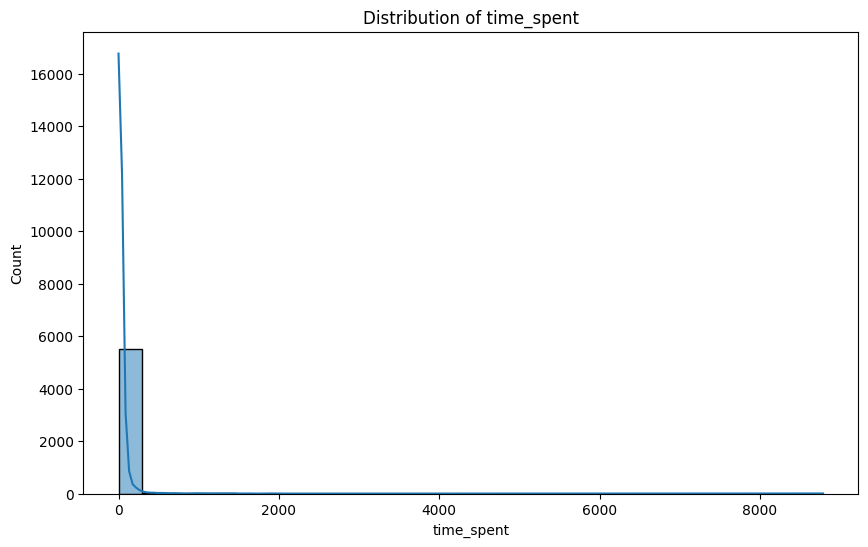

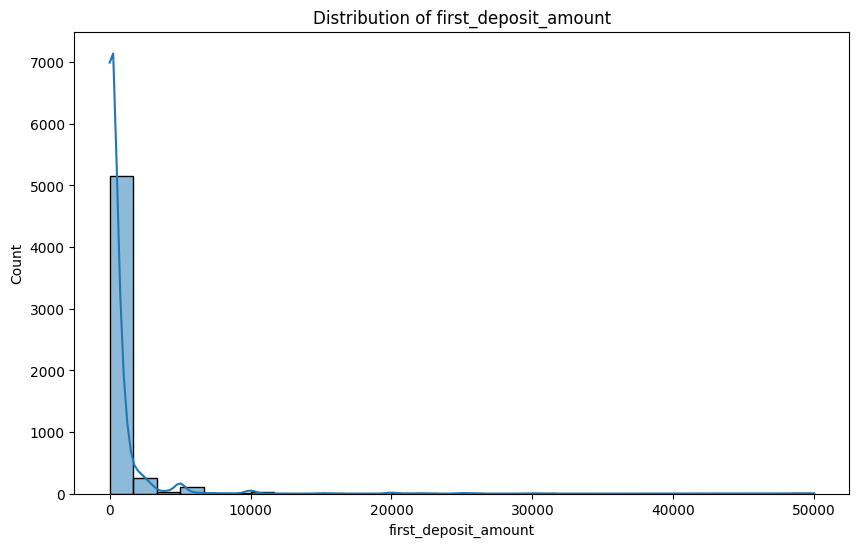

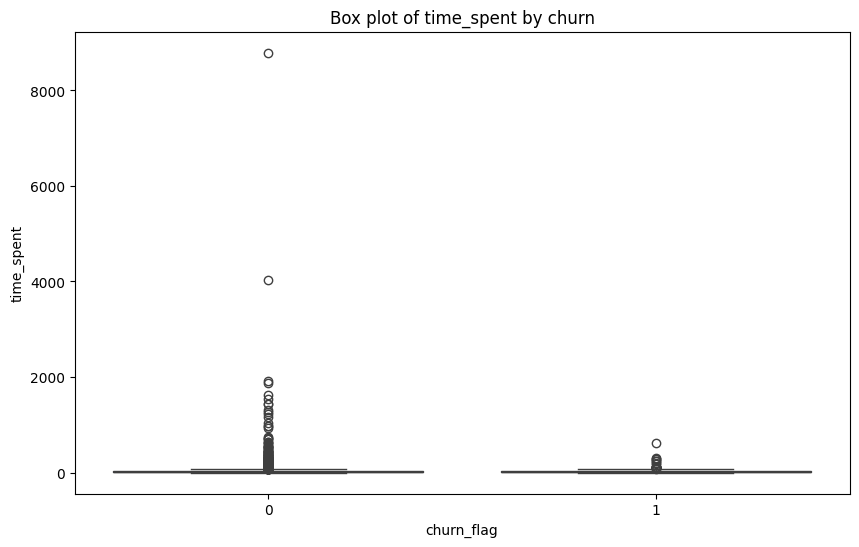

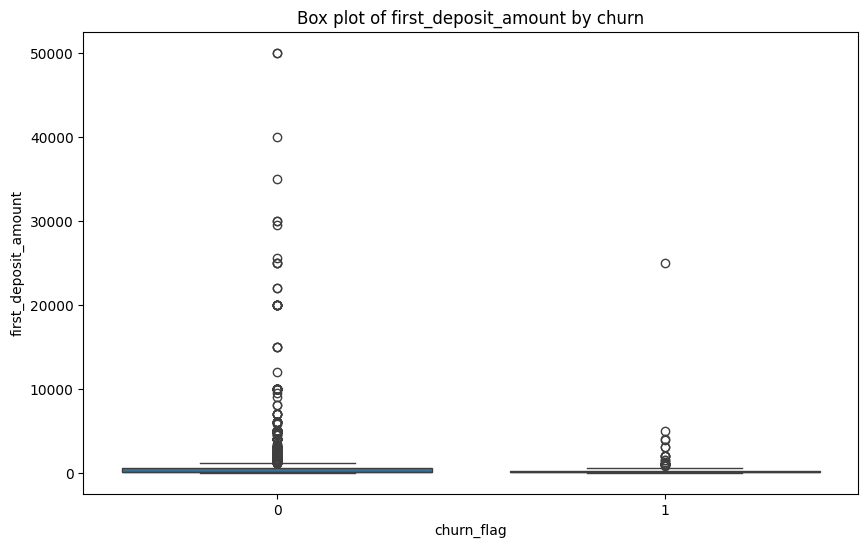

In [7]:
# Distribution plot for numerical features
num_cols = ['time_spent', 'first_deposit_amount']  # Add more numerical columns if needed
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plot for numerical features to detect outliers
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df)
    plt.title(f'Box plot of {col} by churn')
    plt.show()

### Univariate Analysis | Categorical Features: Frequency distributions

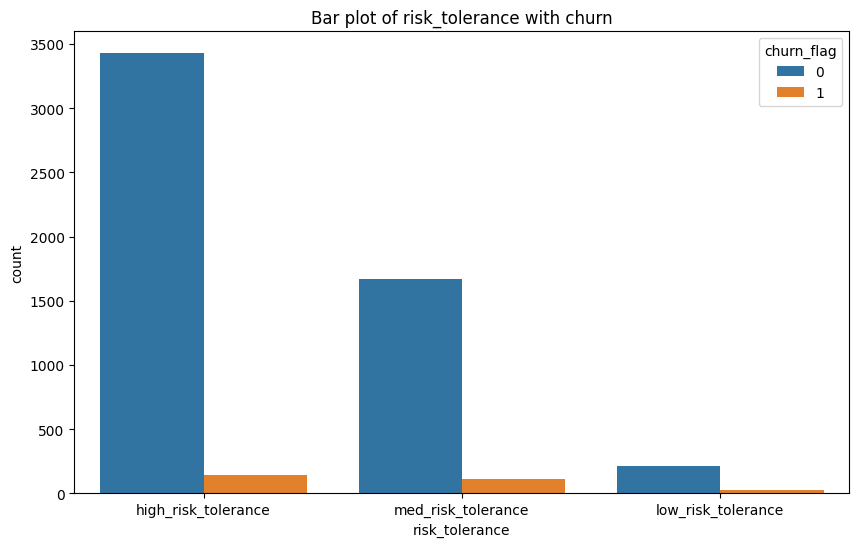

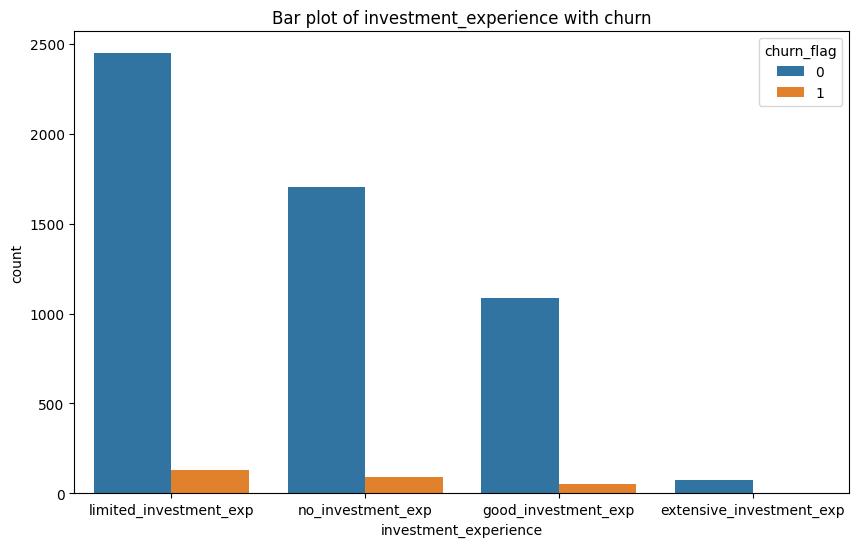

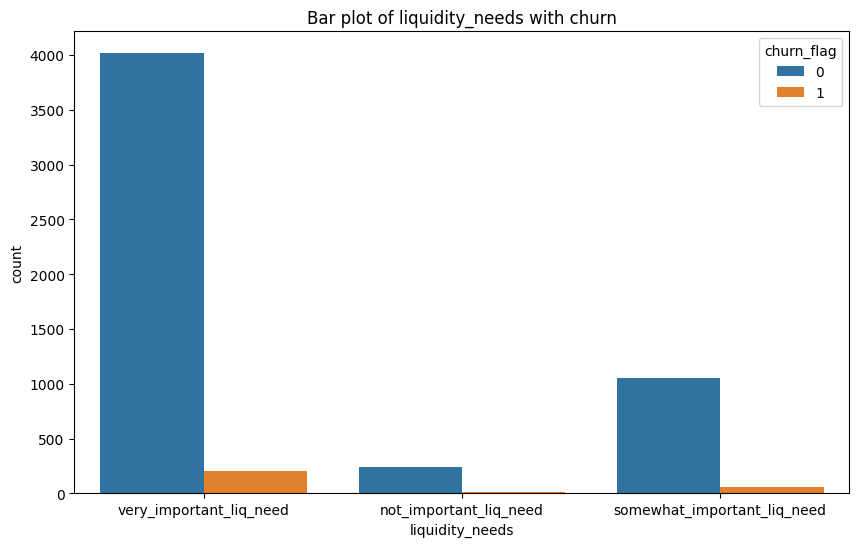

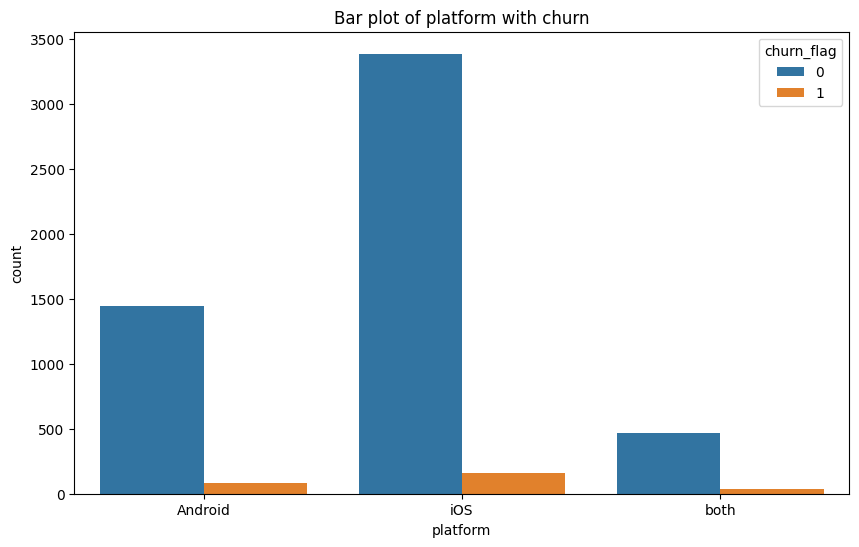

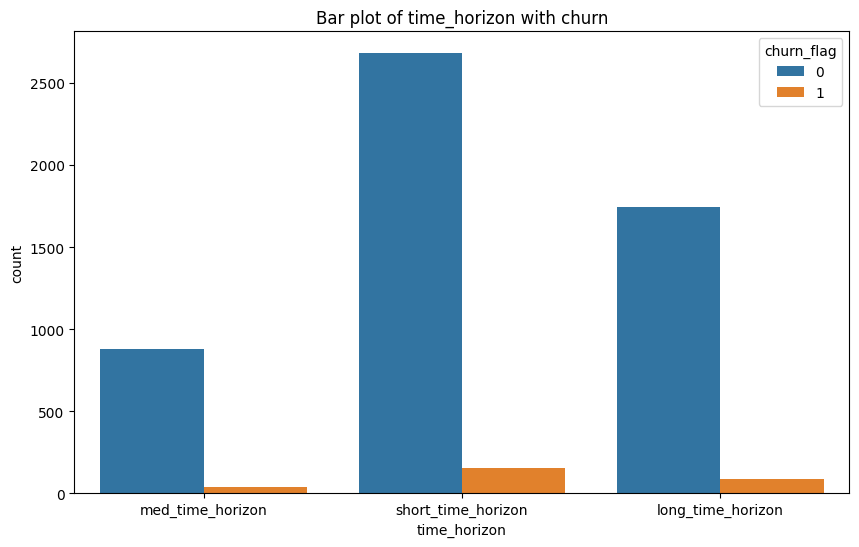

In [8]:
# Bar plot for categorical features
cat_cols = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'time_horizon']
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='churn_flag')
    plt.title(f'Bar plot of {col} with churn')
    plt.show()

### Bivariate Analysis | Comparing Numerical Features with Churn

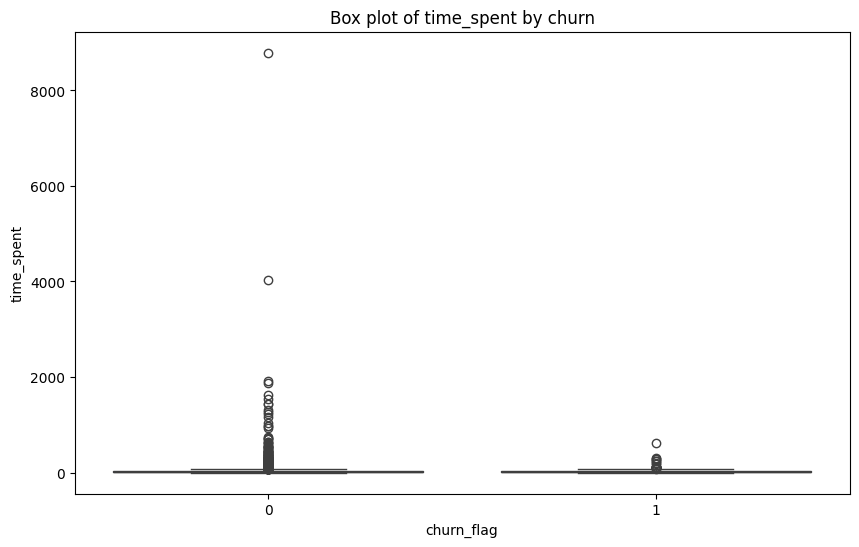

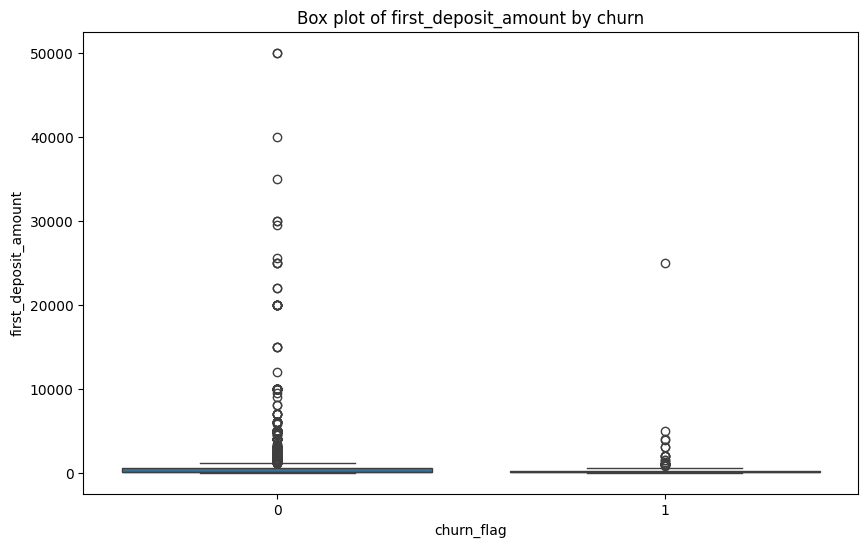

In [9]:
# Box plot for numerical columns grouped by churn
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df)
    plt.title(f'Box plot of {col} by churn')
    plt.show()

# Commenting out bc takes too long
# # Swarm plot for better visualization of all points
# for col in num_cols:
#     plt.figure(figsize=(10, 6))
#     sns.swarmplot(x='churn_flag', y=col, data=df)
#     plt.title(f'Swarm plot of {col} by churn')
#     plt.show()

### Multivariate Analysis | Interactions and Correlations

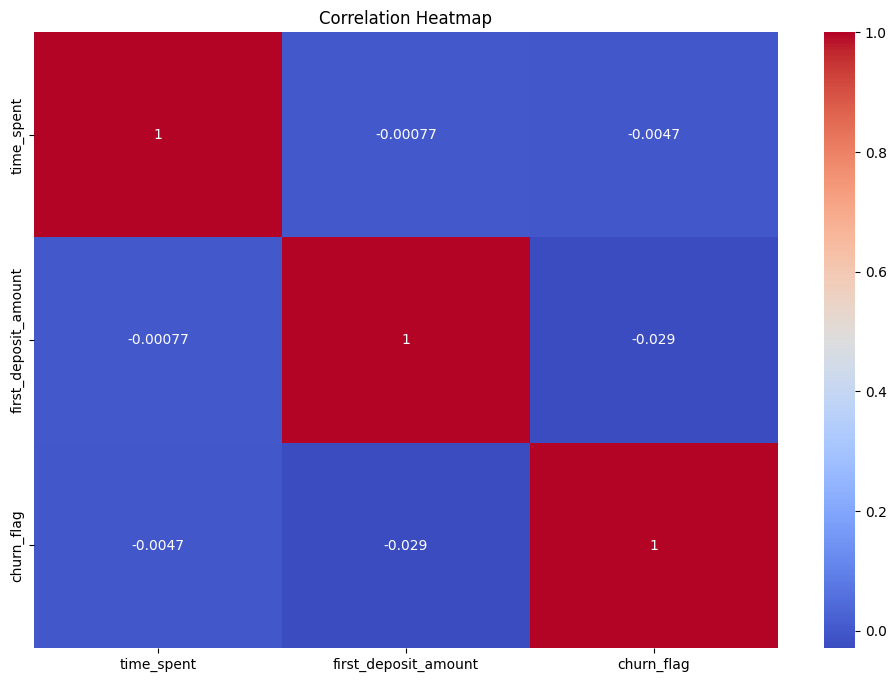

In [12]:
# Correlation matrix and heatmap to understand relationships between numerical variables.
# Filter out only numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix and heatmap to understand relationships between numerical variables.
plt.figure(figsize=(12, 8))
corr = num_cols.corr()  # Calculate correlation on numerical columns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

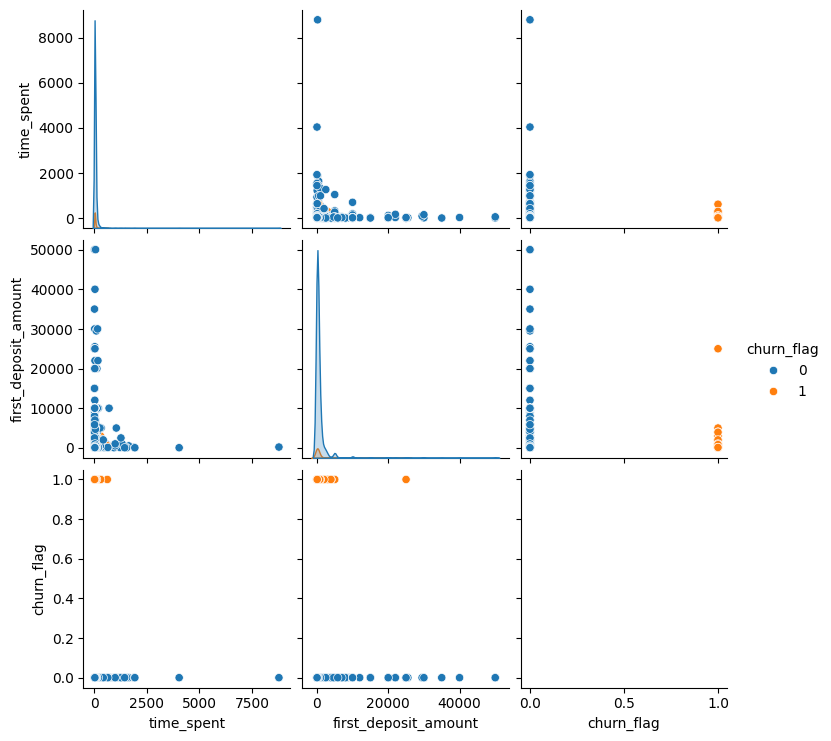

In [13]:
# Pair plot to see pairwise relationships
sns.pairplot(df, hue='churn_flag', vars=num_cols)
plt.show()

### Understanding Distribution Patterns (Normal, Bimodal, Skewed)

C:\Users\cheng\AppData\Local\Temp\ipykernel_16692\747051676.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x=col, shade=True, hue='churn_flag')


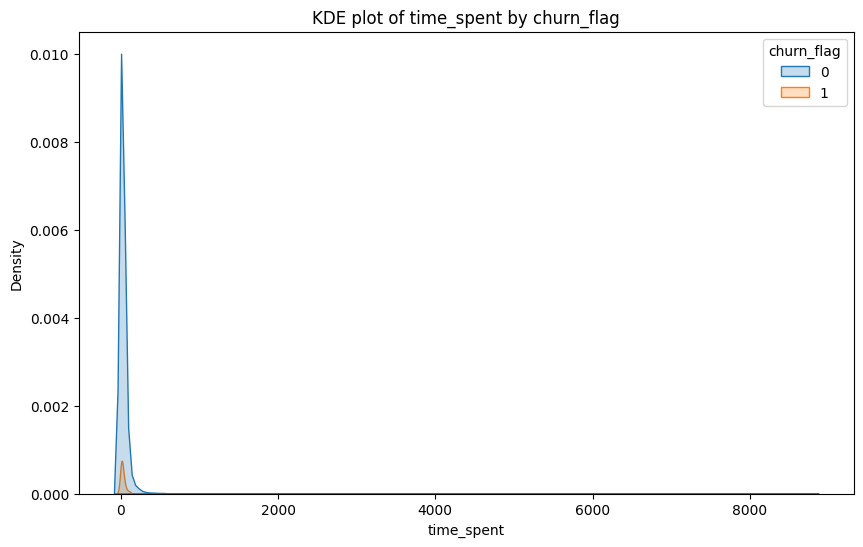

C:\Users\cheng\AppData\Local\Temp\ipykernel_16692\747051676.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x=col, shade=True, hue='churn_flag')


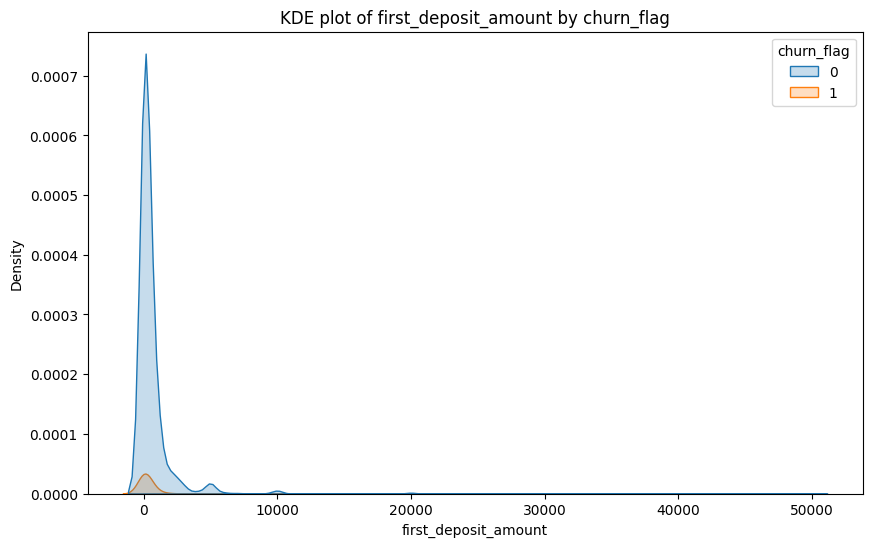

In [19]:
# KDE plot to understand the distribution shape
# Ensure 'churn_flag' is treated as categorical since hue parameter needs to be a category
df['churn_flag'] = df['churn_flag'].astype('category')
# Filter numerical columns only otherwise it will break
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# KDE plot to understand the distribution shape
for col in num_cols:
    plt.figure(figsize=(10, 6))

    # Plot KDE with churn_flag as hue, but only for numeric columns
    sns.kdeplot(data=df, x=col, shade=True, hue='churn_flag')

    plt.title(f'KDE plot of {col} by churn_flag')
    plt.show()

### Categorical Variables and Churn Relationships

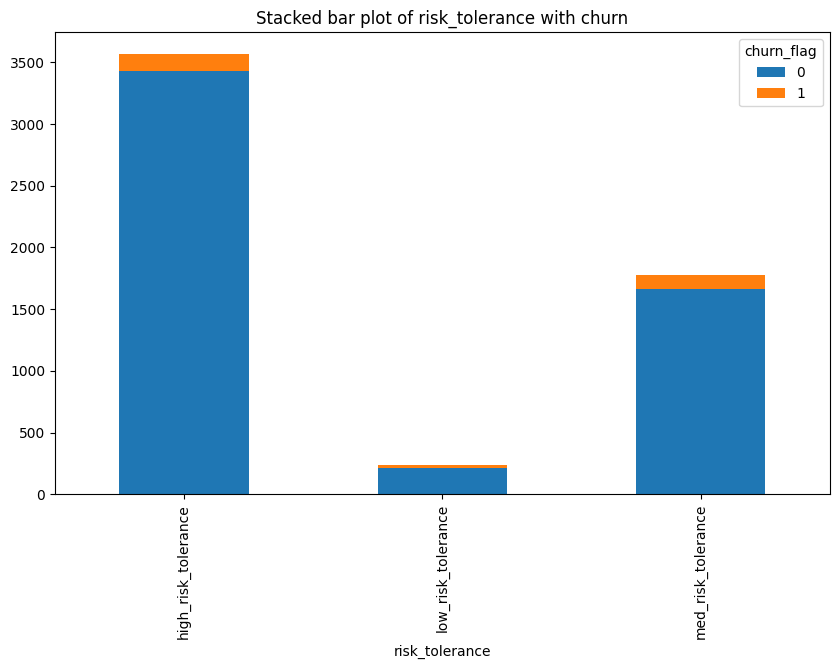

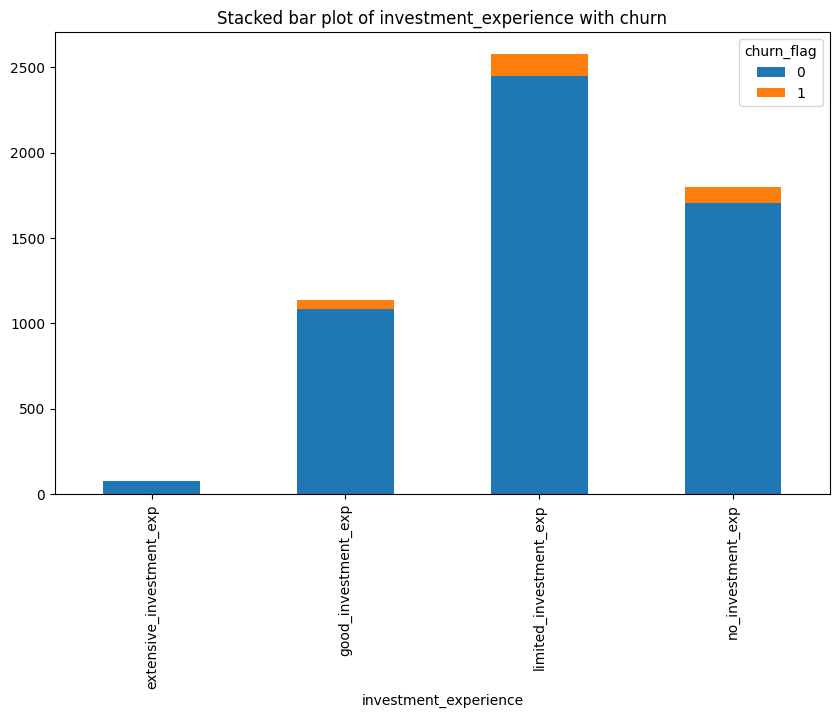

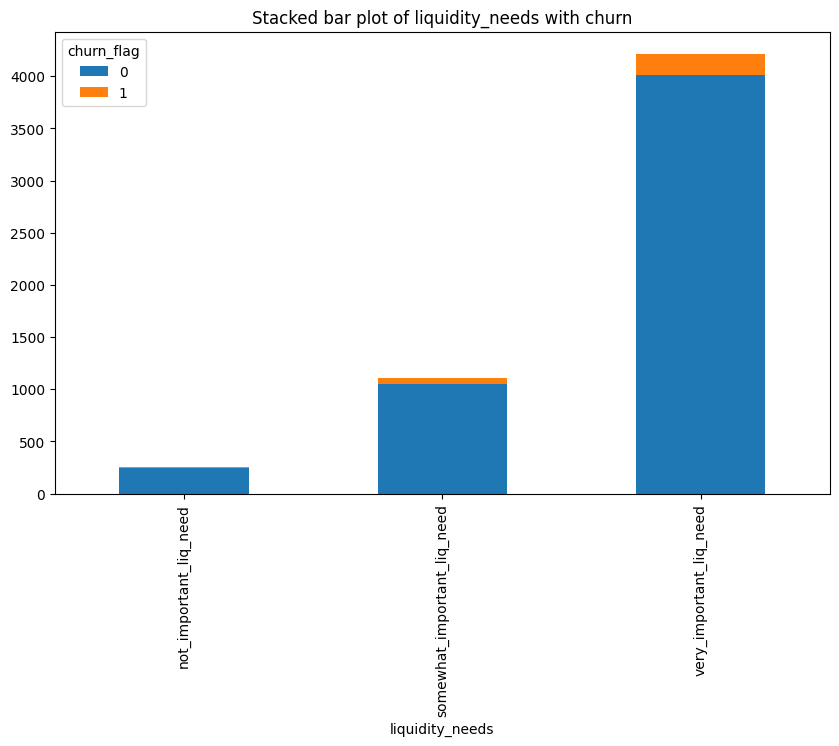

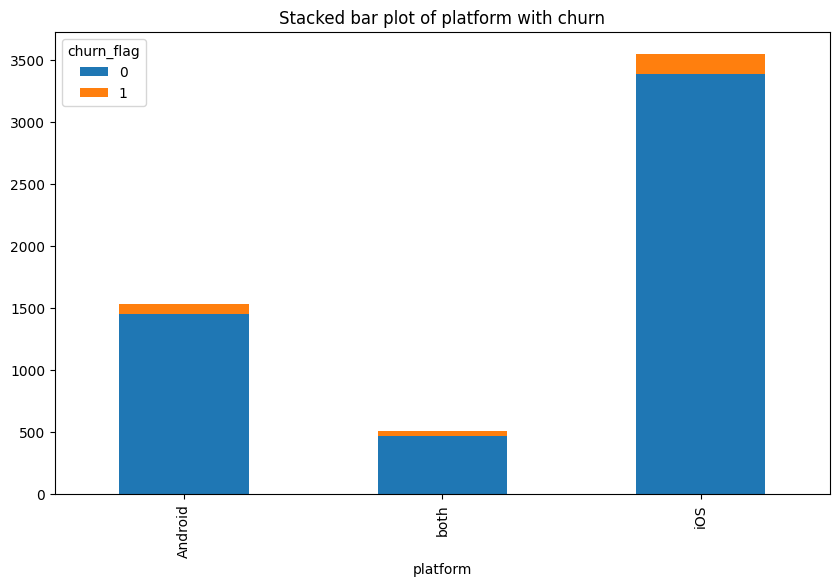

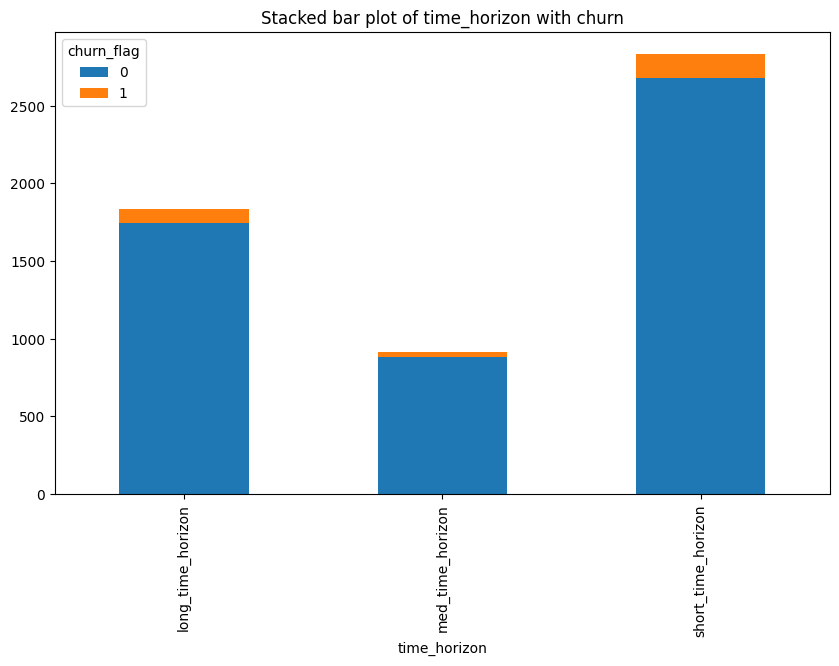

In [20]:
# Bar plots and stacked bar charts to visualize relationships between churn and categorical features.
# Stacked bar plots for churn and categorical variables
for col in cat_cols:
    pd.crosstab(df[col], df['churn_flag']).plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Stacked bar plot of {col} with churn')
    plt.show()


### Variance, Standard Deviation, and Spread of numerical variables

In [21]:
# Variance and Standard Deviation of numerical columns
df[num_cols].var()
df[num_cols].std()

# See Box plot to visualize spread (already covered in previous sections)


time_spent               155.080551
first_deposit_amount    2118.323263
dtype: float64

### Identifying Outliers using Z-Scores on numerical variables

In [22]:
# Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[num_cols]))
outliers = (z_scores > 3).sum(axis=0)  # Count the number of outliers for each column
print(f'Number of outliers per column: {outliers}')


Number of outliers per column: time_spent              31
first_deposit_amount    62
dtype: int64


C:\Users\cheng\AppData\Local\Temp\ipykernel_16692\3188113231.py:2: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = np.abs(stats.zscore(df[num_cols]))


### Multicollinearity

In [23]:
# Calculate VIF for each numerical column
# Variance Inflation Factor (VIF) checks for multicollinearity between numerical variables:
vif_data = pd.DataFrame()
vif_data['Feature'] = num_cols
vif_data['VIF'] = [variance_inflation_factor(df[num_cols].values, i) for i in range(len(num_cols))]

print(vif_data)


                Feature       VIF
0            time_spent  1.003801
1  first_deposit_amount  1.003801
